### Walk through the baseline model for the [Ariel ML challenge 2021](https://www.ariel-datachallenge.space/).

What this notebooks does: 
- access the data using an ArielMLDataset utility class
- plot a random input light curve
- use some simple preprocessing steps for the input light curves
- train the baseline model for a subset of the data (by default)
- produce an evaluation file for the baseline model

What this notebooks does *not*:
- train on the full dataset
- explore alternative training losses
- optimise of the current model architecture
- discuss other models or architectures
- include additional parameters (only the light curves are used) 

# Note: Requires at least **24GB** of RAM or your computer would crash, for linux. For Windows, please see as you fit, but recommends to have at least the same amount of RAM in case your computer crash. 

In [35]:
# General imports
import numpy as np
import matplotlib.pylab as plt
import torch

    
from pathlib import Path

In [36]:
# Device agnostic 
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

## Data access

In [37]:
# paths to data dirs
lc_train_path = "/home/chowjunwei37/Documents/data/training_set/noisy_train"
params_train_path = "/home/chowjunwei37/Documents/data/training_set/params_train"
lc_test_path = "/home/chowjunwei37/Documents/data/test_set/noisy_test"

# Import Dataset class 
from utils import ArielMLDataset

### let's plot a random spectral light curve, just for fun

Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


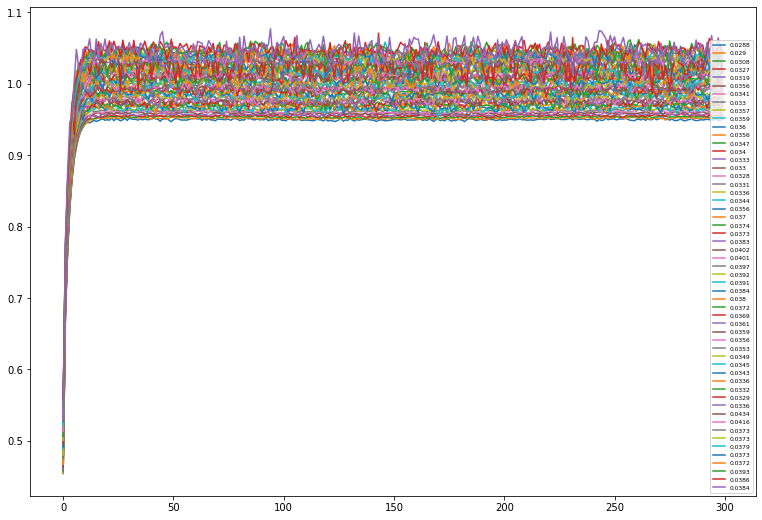

In [38]:
dataset = ArielMLDataset(lc_train_path, params_train_path, shuffle=True)

idx = np.random.randint(len(dataset))
item = dataset[idx]
offsets = np.linspace(-0.05, 0.05, item['lc'].shape[0])
f, ax = plt.subplots(figsize=(13,9))
plt.plot(item['lc'].T.detach().numpy() + offsets , label=None)
ax.legend([round(x, 4) for x in item['target'].detach().numpy()], fontsize=6, loc='lower right')
plt.savefig("saved_fig.png", dpi=500)

## Define simples preprocessing steps
- smoothing 
- clipping
- normalisation per wavelength
- removing ramp?

In [39]:
from utils import simple_transform

Let's include these steps in the datasets for convenience

In [40]:
random_seed = 0
train_size = 512
val_size = 1024
test_size = 1024

# Training
dataset_train = ArielMLDataset(lc_train_path, params_train_path, shuffle=True, start_ind=0, 
                               max_size=train_size, transform=simple_transform, seed=random_seed)
# Validation
dataset_val = ArielMLDataset(lc_train_path, params_train_path, shuffle=True, start_ind=train_size, 
                             max_size=val_size, transform=simple_transform, seed=random_seed)

# Testing
dataset_test = ArielMLDataset(lc_train_path, params_train_path, start_ind=train_size+val_size, 
                              shuffle=True, max_size=test_size, transform=simple_transform, seed=random_seed)

# Evaluation : no output path available here, this will only be used for submission
dataset_eval = ArielMLDataset(lc_test_path, shuffle=False, transform=simple_transform, transpose=True)

Let's define the corresponding data loaders, still using Pytorch utils module

In [41]:
from torch.utils.data.dataloader import DataLoader

batch_size = int(train_size / 4)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size)
loader_test = DataLoader(dataset_test, batch_size=batch_size)
loader_eval = DataLoader(dataset_eval, batch_size=100, shuffle=False, num_workers=2)

### Challenge's Metric

The scoring system used for evaluation is defined here: https://www.ariel-datachallenge.space/ML/documentation/scoring

Let's define it roughly here, with unity weights as we don't have the actual weights available. Note that this might likely lead to conservative (pessimistic) score estimation as the real metric gives smaller weights to the hardest samples (in terms of signal-to-noise), whereas here all the samples have equal weighting.

In [42]:
from utils import ChallengeMetric
    
challenge_metric = ChallengeMetric()

## Models

A constant prediction model for reference

In [43]:
naive_1 = lambda x: torch.ones(x.shape[:-1]) * 0.06  

The baseline model, a fully connected neural network with 2 hidden layers with ReLU activation functions.

In [44]:
from utils import Baseline, BaselineLSTM
    
# baseline = Baseline().double().to(device)
baseline = BaselineLSTM(hidden_dim=512, batch_size=batch_size, device=device).double().to(device)
baseline

BaselineLSTM(
  (lstm): LSTM(55, 512, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=55, bias=True)
)

### Training the baseline

In [45]:
from torch.optim import Adam
from torch.nn import MSELoss, L1Loss

opt = Adam(baseline.parameters(), lr=0.0005)
loss_function = MSELoss()  # Alternatives could be ChallengeMetric() or L1Loss()

train_losses = []
val_losses = []
val_scores = []
best_val_score = 0.        

In [46]:
# save_from = 3
# epochs = 200

# for epoch in range(1, 1+epochs):
#     print(epoch)
#     train_loss = 0
#     val_loss = 0
#     val_score = 0
#     baseline.train()
#     for k, item in enumerate(loader_train):
#         pred = baseline(item['lc'])
#         loss = loss_function(item['target'], pred)
#         opt.zero_grad()
#         loss.backward()
#         opt.step()    
#         train_loss += loss.detach().item()
#     train_loss = train_loss / len(loader_train)
    
#     baseline.eval()
#     for k, item in enumerate(loader_val):
#         pred = baseline(item['lc'])
#         loss = loss_function(item['target'], pred)
#         score = challenge_metric.score(item['target'], pred)
#         val_loss += loss.detach().item()
#         val_score += score.detach().item()
#     val_loss /= len(loader_val)
#     val_score /= len(loader_val)
#     print('Training loss', round(train_loss, 6))
#     print('Val loss', round(val_loss, 6))
#     print('Val score', round(val_score, 2))
#     train_losses += [train_loss]
#     val_losses += [val_loss]
#     val_scores += [val_score]
    
#     if epoch >= save_from and val_score > best_val_score:
#         best_val_score = val_score
#         torch.save(baseline, 'outputs/model_state.pt')
    

Let's look at the learning curve

In [47]:
# f, ax = plt.subplots()
# plt.plot(train_losses, '-o', label='Train Loss', markersize=2)
# plt.plot(val_losses, '-o', label='Val Loss', markersize=2)
# plt.xlabel('epochs', fontsize=12)
# plt.ylabel('Mean-Squared Error', fontsize=12)
# plt.yscale('log')
# plt.legend()

# secay = ax.twinx()
# secay.plot()
# secay.plot(val_scores, '-o', label='Val Score', markersize=2, color='black')
# secay.set_xlabel('epochs', fontsize=12)
# secay.set_ylabel('Challenge score (unity weights)', fontsize=12)
# secay.set_ylim(5000,10000)
# pass

let's reload the model with the best validation loss

In [48]:
baseline = torch.load('outputs/model_state_lstm_dropout.pt')
baseline.eval()

BaselineLSTM(
  (lstm): LSTM(55, 512, num_layers=2, batch_first=True, dropout=0.1, bidirectional=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=1024, out_features=55, bias=True)
)

### Compare models on test set

In [49]:
# item = next(iter(loader_test))

# preds = {'naive1': naive_1(item['lc']), 
#          'normal_1000ppm': torch.normal(item['target'], 1e-3),
#          'baseline': baseline(item['lc'])
#         }

# for name, pred in preds.items():
#     print(name, f"\t{challenge_metric.score(item['target'], pred).item():.2f}")

### Produce evaluation vectors
(takes a several mins to run)

In [50]:
%%time
import tqdm
import gc
import os
import pandas as pd
preds = []

try:
    os.remove("outputs/baseline_prediction.txt")
except Exception:
    pass

for k, item in tqdm.tqdm(enumerate(loader_eval)):
        
    pred = pd.DataFrame(baseline(item["lc"]).detach().numpy())

    pred.to_csv(f"outputs/baseline_prediction.txt", mode="a", header=None, index=False, sep="\t")

    del pred

    if k % 10 == 0:
        gc.collect()

539it [1:09:39,  7.75s/it]CPU times: user 5h 19min 20s, sys: 14min 5s, total: 5h 33min 26s
Wall time: 1h 9min 39s



Let's quickly plot the mean results per wavelength

Text(0, 0.5, 'mean prediction per wavelength')

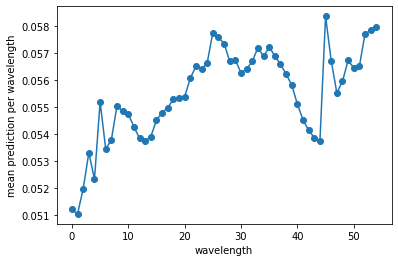

In [54]:
eval_pred = np.loadtxt("outputs/baseline_prediction.txt")
plt.plot(eval_pred.mean(0), '-o')
plt.xlabel('wavelength')
plt.ylabel('mean prediction per wavelength')

And finally save the results as a txt file:

In [55]:
assert eval_pred.shape == (53900, 55)

In [20]:
# import datetime 

# save_path = f'outputs/baseline_evaluation_{datetime.datetime.today().date()}.txt'
# if save_path and (53900, 55) == eval_pred.shape:
#     np.savetxt(save_path, eval_pred, fmt='%.10f', delimiter='\t')